In [ ]:
!pip install pyNN brian2

In [33]:
from brian2 import *
import numpy as np

# Defining Izhikevich model and populations (excitatory & inhibitory)

We've chosen the Izhikevich model, since it's the best trade off between biological plausibility and computational requirements.
In the definition of our neuron model we accounted also for the spatial position in a **2D space** (it could also have been a 1D or 3D space). The values of this parameters will be used for distance dependent properties such as synaptic delay and distance probability connectors.
Theoretically we should use mV/ms as unity measure for states derivatives and mV for states; but we followed the [approach of the CNT-2024 repo](https://github.com/albertoarturovergani/CNT-2024/blob/a246491ffc1215aa63ae53b7f4354dd44048cd95/notebooks/numerical-methods/brian2/2007_Izhikevich.ipynb) in which these are dimensionless.

In [34]:
# Number of cells and ratio of excitatory to inhibitory cells
n_exc = 1089
n_inh = 256
print("{} {}".format(n_exc, n_inh))

# Define neuron model parameters for Izhikevich neurons
eqs = """
dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
du/dt = (a*(b*v - u))/ms  : 1
I : 1
I_noise : 1
a : 1
b : 1
c : 1
d : 1

x : 1
y : 1
"""

# Threshold and reset conditions for Izhikevich neurons
threshold = 'v >= 30'
reset = '''
v = c
u += d
'''

re = np.random.uniform(size=n_exc)
ri = np.random.uniform(size=n_inh)

# Create excitatory population
exc_neurons = NeuronGroup(n_exc, eqs, threshold=threshold, reset=reset, method='euler')
exc_neurons.a = 0.02
exc_neurons.b = 0.25
exc_neurons.c = -65
exc_neurons.d = 2

# Create inhibitory population
inh_neurons = NeuronGroup(n_inh, eqs, threshold=threshold, reset=reset, method='euler')
inh_neurons.a = 0.02
inh_neurons.b = 0.25
inh_neurons.c = -65
inh_neurons.d = 2

# Define spatial structure
exc_neurons.x = np.random.rand(n_exc)
exc_neurons.y = np.random.rand(n_exc)
inh_neurons.x = np.random.rand(n_inh)
inh_neurons.y = np.random.rand(n_inh)

# Initialize membrane potential (v) and recovery variable (u) with uniform distribution
exc_neurons.v = np.random.uniform(-65, -50, n_exc)
exc_neurons.u = "b * v"
inh_neurons.v = np.random.uniform(-65, -50, n_inh)
inh_neurons.u = "b * v"


1089 256


# Projections

We defined an **STDP** mechanism which manages the synaptic plasticity. All the connections have been defined through STDP.
We also managed the **distance dependence in connection probability**, but for simplicity we've applied it only between exc to exc connections.
Another important property we've defined is the **synaptic delay**, as a function of neurons distance. Our 2D space definition is not 100% biologically plausible since when generating X and Y values, we allow repitition of the same values so it can happen that 2 neurons overlap, even though it's probabilistically unlikely. To calculate distances we've normalized the position values, in order to obtain a min distance of 0 and a max distance of 1.41 (sqrt(2)); using normalized values, we also overcome the problem for which inhibitory space is smaller than excitatory space (256x256 vs 1089x1089).
To embed inhibitory connections we relied on negative weights.

In [35]:
# Define the STDP mechanism
tau_pre = 20*ms
tau_post = tau_pre
A_pre = 0.1
A_post = -A_pre
w_max = 1.00

stdp_eqs = '''
w : 1
dapre/dt = -apre / tau_pre : 1 (event-driven)
dapost/dt = -apost / tau_post : 1 (event-driven)
'''

on_pre_exc = '''
v_post += w
apre += A_pre
w = clip(w + apost, 0, w_max)
'''

on_pre_inh = '''
v_post += w
apre += A_pre
w = clip(w + apost, -w_max, 0)
'''

on_post_exc = '''
apost += A_post
w = clip(w + apre, 0, w_max)
'''

on_post_inh = '''
apost += A_post
w = clip(w + apre, -w_max, 0)
'''

In [36]:
# Distance-dependent probability function
def distance_dependent_prob(i, j):
    dx = exc_neurons.x[i] - exc_neurons.x[j]
    dy = exc_neurons.y[i] - exc_neurons.y[j]
    norm_dx = (exc_neurons.x[i] / 1089) - (exc_neurons.x[j] / 1089)
    norm_dy = (exc_neurons.y[i] / 1089) - (exc_neurons.y[j] / 1089)
    d = np.sqrt(dx**2 + dy**2)
    norm_d = d = np.sqrt(norm_dx**2 + norm_dy**2)
    return np.exp(-d/100.0) / 100, norm_d

In [37]:
# Connect excitatory neurons to each other with distance-dependent STDP
syn_exc_exc = Synapses(exc_neurons, exc_neurons, model=stdp_eqs, on_pre=on_pre_exc, on_post=on_post_exc)
for i in range(n_exc):
    for j in range(n_exc):
      distance_dependent_prob_value, norm_distance = distance_dependent_prob(i, j)
      if i != j and np.random.rand() < distance_dependent_prob_value:
          syn_exc_exc.connect(i=i, j=j)
          syn_exc_exc.delay[i, j] = (0.2 * ms) + (norm_distance * (2 * ms))

syn_exc_exc.w = 'rand() * w_max'

# Connect inhibitory neurons to each other with STDP
syn_inh_inh = Synapses(inh_neurons, inh_neurons, model=stdp_eqs, on_pre=on_pre_inh, on_post=on_post_inh)
syn_inh_inh.connect(p=0.02)
syn_inh_inh.w = '-(rand() * w_max)'
syn_inh_inh.delay = '(0.2 * ms) + sqrt(((x_pre / 256) - (x_post / 256))**2 + ((y_pre / 256) - (y_post / 256))**2) * (2 * ms)'

# Connect excitatory neurons to inhibitory neurons with STDP
syn_exc_inh = Synapses(exc_neurons, inh_neurons, model=stdp_eqs, on_pre=on_pre_exc, on_post=on_post_inh)
syn_exc_inh.connect(p=0.02)
syn_exc_inh.w = 'rand() * w_max'
syn_exc_inh.delay = '(0.2 * ms) + sqrt(((x_pre / 1089) - (x_post / 256))**2 + ((y_pre / 1089) - (y_post / 256))**2) * (2 * ms)'

# Connect inhibitory neurons to excitatory neurons with STDP
syn_inh_exc = Synapses(inh_neurons, exc_neurons, model=stdp_eqs, on_pre=on_pre_inh, on_post=on_post_exc)
syn_inh_exc.connect(p=0.02)
syn_inh_exc.w = '-(rand() * w_max)'
syn_inh_exc.delay = '(0.2 * ms) + sqrt(((x_pre / 256) - (x_post / 1089))**2 + ((y_pre / 256) - (y_post / 1089))**2) * (2 * ms)'

# Thalamic stimulus

In [38]:
# Thalamic stimulus parameters
n_thalamic_cells = 20
rate = 100 * Hz

# Create thalamic cells as Poisson spike generators
thalamic_cells = PoissonGroup(n_thalamic_cells, rates=rate)

# Record spikes from thalamic cells
thalamic_spikes = SpikeMonitor(thalamic_cells)

# Connect thalamic cells to excitatory neurons
syn_thalamic_exc = Synapses(thalamic_cells, exc_neurons, on_pre='v_post += 2.00')
syn_thalamic_exc.connect(p=0.02)

# Connect thalamic cells to inhibitory neurons
syn_thalamic_inh = Synapses(thalamic_cells, inh_neurons, on_pre='v_post += 2.00')
syn_thalamic_inh.connect(p=0.02)

# Running simulation

In [39]:
# Print population keys to verify
print("Thalamic cells: ", thalamic_cells)
print("Excitatory neurons: ", exc_neurons)
print("Inhibitory neurons: ", inh_neurons)

Thalamic cells:  PoissonGroup(20, rates=100. * hertz)
Excitatory neurons:  NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
Inhibitory neurons:  NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


In [40]:
# Record spikes
exc_spikes = SpikeMonitor(exc_neurons)
inh_spikes = SpikeMonitor(inh_neurons)

# Record state variables
state_mon_exc = StateMonitor(exc_neurons, ['v', 'u'], record=True)
state_mon_inh = StateMonitor(inh_neurons, ['v', 'u'], record=True)

# Assigning random noise to neurons
exc_neurons.run_regularly("I_noise = 3*randn()", dt=1 * ms)
inh_neurons.run_regularly("I_noise = 2*randn()", dt=1 * ms)

# Record the weights for a subset of synapses
syn_exc_mon = StateMonitor(syn_exc_exc, 'w', record=syn_exc_exc[:, :10])
syn_inh_mon = StateMonitor(syn_inh_inh, 'w', record=syn_inh_inh[:, :10])

# Adding the previously defined components
net = Network(collect())
net.add(thalamic_cells, thalamic_spikes, syn_thalamic_exc, syn_thalamic_inh)
net.add(exc_neurons, inh_neurons, syn_inh_exc, syn_inh_inh, syn_exc_exc, syn_exc_inh, exc_spikes, inh_spikes, state_mon_exc, state_mon_inh)

# Run the simulation
net.run(1000*ms)

# Analyzing the simulation

Differently from the Integrate and Fire model, the Izhikevich one doesn't provide any conductance value; so we analyze the spikes, and the 2 state variables.

**STDP analysis**

These 2 plots show that the STDP mechanism is producing changes in synapses weights.

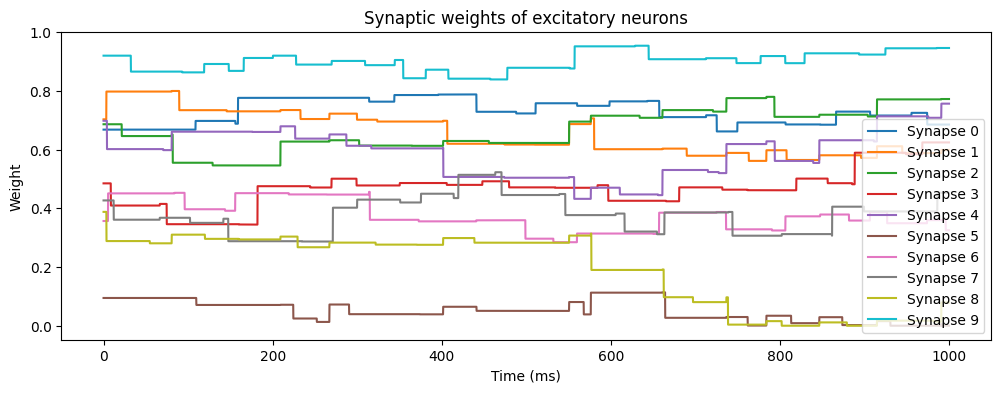

In [41]:
# Plot excitatory synaptic weights
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(syn_exc_mon.t/ms, syn_exc_mon.w[i], label=f'Synapse {i}')
plt.xlabel('Time (ms)')
plt.ylabel('Weight')
plt.title('Synaptic weights of excitatory neurons')
plt.legend()
plt.show()

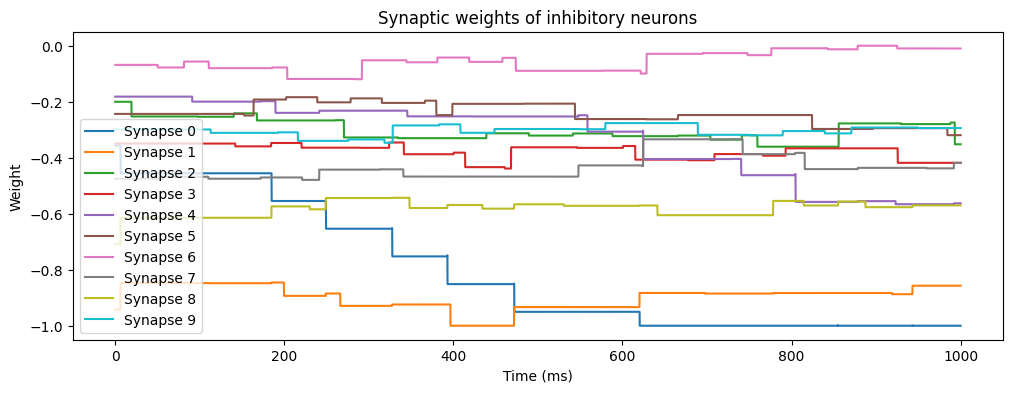

In [42]:
# Plot inhibitory synaptic weights
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(syn_inh_mon.t/ms, syn_inh_mon.w[i], label=f'Synapse {i}')
plt.xlabel('Time (ms)')
plt.ylabel('Weight')
plt.title('Synaptic weights of inhibitory neurons')
plt.legend()
plt.show()

**Spikes**

In [43]:
# Number of spikes
len(exc_spikes.i)

16346

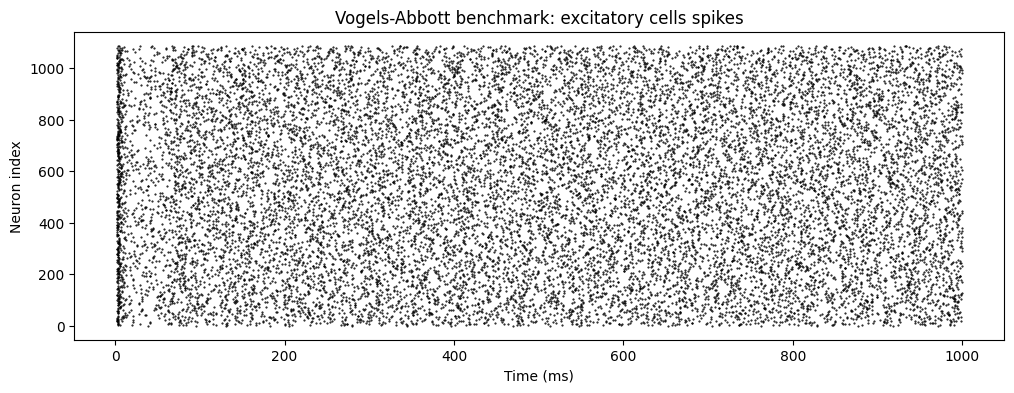

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(exc_spikes.t/ms, exc_spikes.i, '.k', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Vogels-Abbott benchmark: excitatory cells spikes')
plt.show()

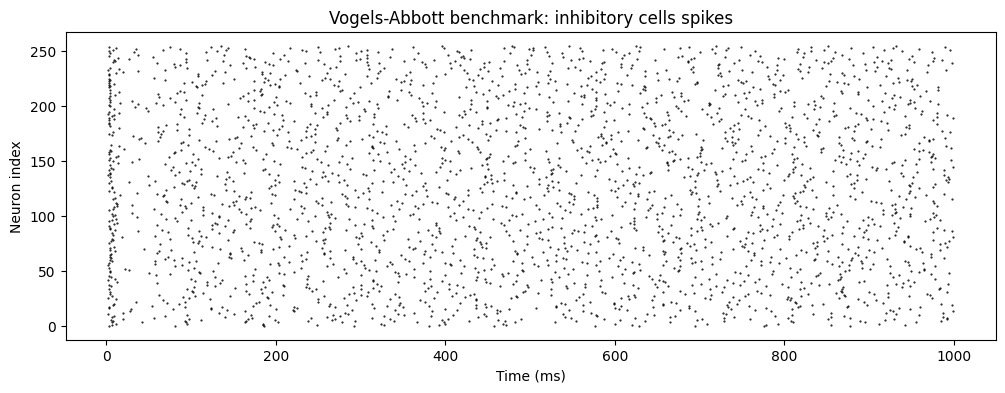

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(inh_spikes.t/ms, inh_spikes.i, '.k', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Vogels-Abbott benchmark: inhibitory cells spikes')
plt.show()

**Membrane potentials**

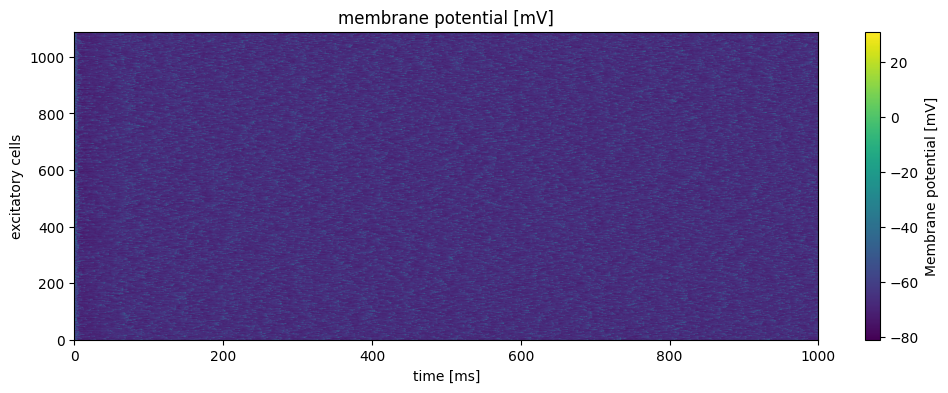

In [46]:
# Convert recorded data to a 2D array
v_values = state_mon_exc.v

# Plotting
plt.figure(figsize=(12, 4))
plt.imshow(v_values, aspect='auto', cmap='viridis', extent=[0, 1000, 0, n_exc])
plt.colorbar(label='Membrane potential [mV]')
plt.xlabel('time [ms]')
plt.ylabel('excitatory cells')
plt.title('membrane potential [mV]')
plt.show()

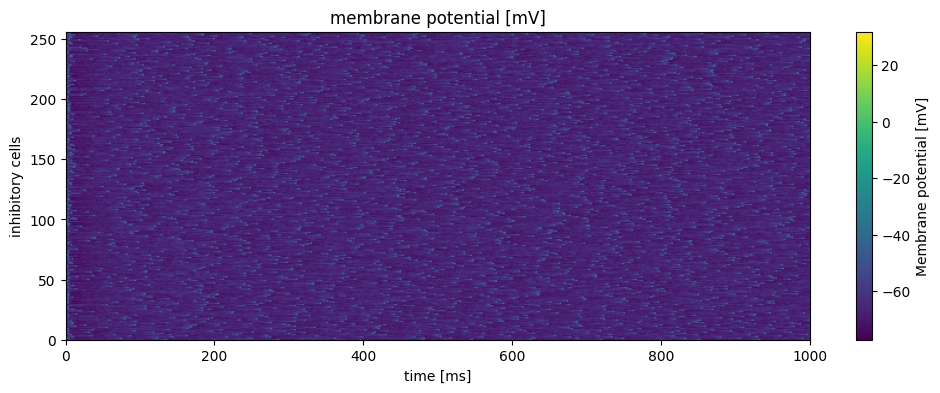

In [47]:
# Convert recorded data to a 2D array
v_values = state_mon_inh.v

# Plotting
plt.figure(figsize=(12, 4))
plt.imshow(v_values, aspect='auto', cmap='viridis', extent=[0, 1000, 0, n_inh])
plt.colorbar(label='Membrane potential [mV]')
plt.xlabel('time [ms]')
plt.ylabel('inhibitory cells')
plt.title('membrane potential [mV]')
plt.show()

**Recovery variables**

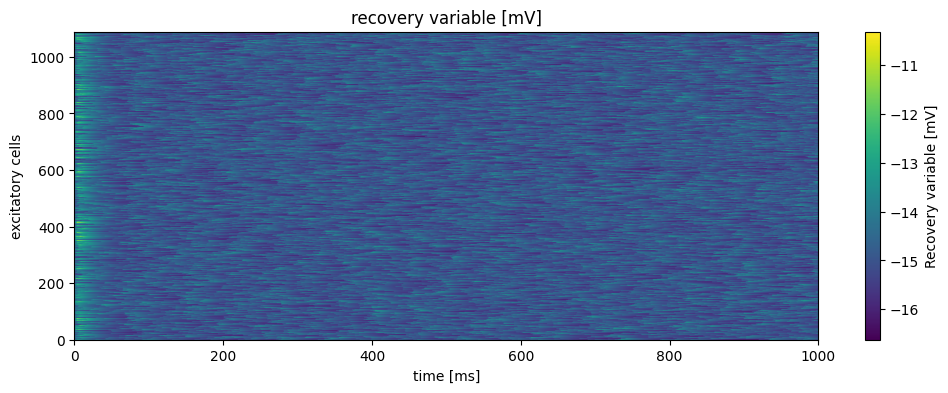

In [48]:
# Convert recorded data to a 2D array
u_values = state_mon_exc.u

# Plotting
plt.figure(figsize=(12, 4))
plt.imshow(u_values, aspect='auto', cmap='viridis', extent=[0, 1000, 0, n_exc])
plt.colorbar(label='Recovery variable [mV]')
plt.xlabel('time [ms]')
plt.ylabel('excitatory cells')
plt.title('recovery variable [mV]')
plt.show()

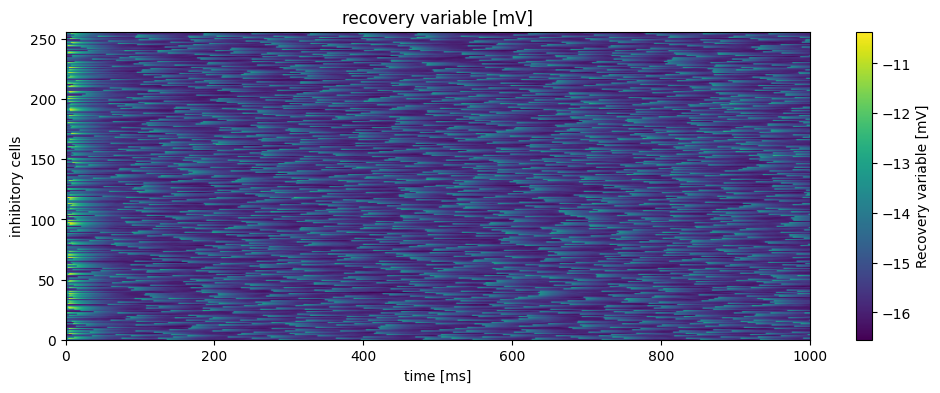

In [49]:
# Convert recorded data to a 2D array
u_values = state_mon_inh.u

# Plotting
plt.figure(figsize=(12, 4))
plt.imshow(u_values, aspect='auto', cmap='viridis', extent=[0, 1000, 0, n_inh])
plt.colorbar(label='Recovery variable [mV]')
plt.xlabel('time [ms]')
plt.ylabel('inhibitory cells')
plt.title('recovery variable [mV]')
plt.show()

# Analyzing single cells

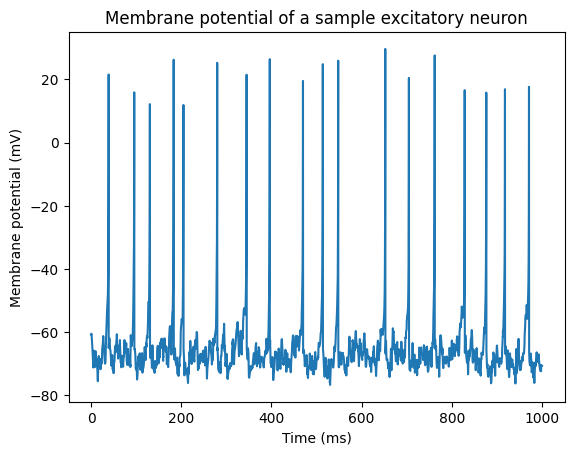

In [50]:
# Plot membrane potential of a sample excitatory neuron
plt.figure()
plt.plot(state_mon_exc.t/ms, state_mon_exc[0].v)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of a sample excitatory neuron')
plt.show()

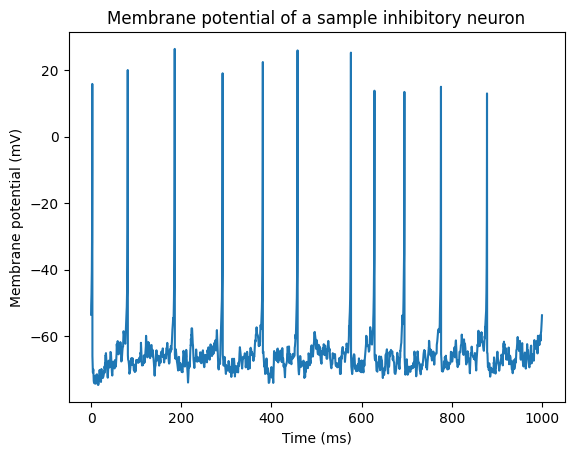

In [51]:
# Plot membrane potential of a sample inhibitory neuron
plt.figure()
plt.plot(state_mon_inh.t/ms, state_mon_inh[0].v)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of a sample inhibitory neuron')
plt.show()

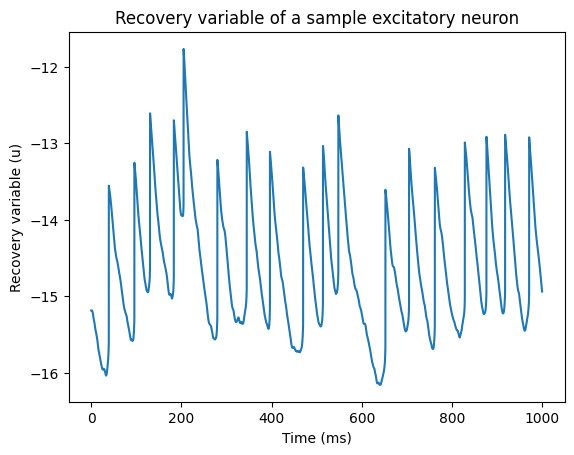

In [52]:
# Plot recovery variable of a sample excitatory neuron
plt.figure()
plt.plot(state_mon_exc.t/ms, state_mon_exc[0].u)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable (u)')
plt.title('Recovery variable of a sample excitatory neuron')
plt.show()

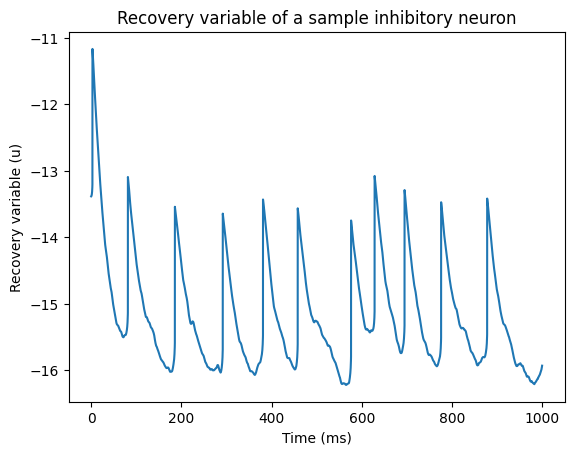

In [53]:
# Plot recovery variable of a sample inhibitory neuron
plt.figure()
plt.plot(state_mon_inh.t/ms, state_mon_inh[0].u)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable (u)')
plt.title('Recovery variable of a sample inhibitory neuron')
plt.show()